# Breast Cancer Decision Tree (From Scratch)

The objective of this notebook is to build a Decision Tree classifier (no scikit-learn) using **Gini impurity** to classify patients' `Status` as `Alive` or `Dead`. The notebook trains the model across epochs 1–20 and plots validation accuracy and loss vs epoch.

**Notes:**
- Implementation uses only `numpy`, `pandas`, and `matplotlib`.
- Missing values: numerical → mean, categorical → mode.
- Max depth = 5.  


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import random
import math
import os

# For reproducibility for parts where we want repeatable runs
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [3]:
# Load dataset
df = pd.read_csv(r"C:\Users\TUF\Downloads\Breast_Cancer.csv")
print('Dataset loaded. Shape:', df.shape)
df.head()

Dataset loaded. Shape: (4024, 16)


,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


#### Exploratory Data Analysis

In [4]:
print('Columns:', list(df.columns))
print('\nMissing values per column:')
print(df.isnull().sum())

Columns: ['Age', 'Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status', 'Progesterone Status', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months', 'Status']

Missing values per column:
Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64


In [5]:
# Target column assumed to be named 'Status' with values 'Alive'/'Dead' (case-insensitive).
if 'Status' not in df.columns:
    raise KeyError("Expected target column 'Status' in CSV.")

# Standardize target
df['Status'] = df['Status'].astype(str).str.strip().str.capitalize()
df = df[df['Status'].isin(['Alive','Dead'])].copy()
print('\nValue counts for Status:') 
print(df['Status'].value_counts())


Value counts for Status:
Status
Alive    3408
Dead      616
Name: count, dtype: int64


In [6]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols and c != 'Status']

print('\nNumeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)


Numeric columns: ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']
Categorical columns: ['Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'Grade', 'A Stage', 'Estrogen Status', 'Progesterone Status']


In [7]:
# Fill missing values: numeric -> mean, categorical -> mode
df_clean = df.copy()

for col in numeric_cols:
    if df_clean[col].isnull().any():
        mean_val = df_clean[col].mean()
        df_clean[col] = df_clean[col].fillna(mean_val)

for col in categorical_cols:
    if df_clean[col].isnull().any():
        mode_val = df_clean[col].mode(dropna=True)
        if len(mode_val) > 0:
            df_clean[col] = df_clean[col].fillna(mode_val[0])
        else:
            df_clean[col] = df_clean[col].fillna('Unknown')

# Manual label encoding for categorical columns
label_encoders = {}
for col in categorical_cols:
    uniques = list(df_clean[col].astype(str).unique())
    mapping = {v:i for i,v in enumerate(uniques)}
    label_encoders[col] = mapping
    df_clean[col] = df_clean[col].astype(str).map(mapping)

# Encode target: Alive->0, Dead->1 (so loss = 1 - accuracy makes sense)
target_map = {'Alive':0, 'Dead':1}
df_clean['Status'] = df_clean['Status'].map(target_map)

print('\nAfter cleaning and encoding:')
print(df_clean.head())
print('\nCounts of target after encoding:')
print(df_clean['Status'].value_counts())


After cleaning and encoding:
   Age  Race  Marital Status  T Stage   N Stage  6th Stage  differentiate  \
0   68     0               0         0        0          0              0   
1   50     0               0         1        1          1              1   
2   58     0               1         2        2          2              1   
3   58     0               0         0        0          0              0   
4   47     0               0         1        0          3              0   

   Grade  A Stage  Tumor Size  Estrogen Status  Progesterone Status  \
0      0        0           4                0                    0   
1      1        0          35                0                    0   
2      1        0          63                0                    0   
3      0        0          18                0                    0   
4      0        0          41                0                    0   

   Regional Node Examined  Reginol Node Positive  Survival Months  Status  
0   

#### Train-Test spliting 

In [8]:
#from typing import Tuple

def train_val_split(df, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    perm = np.random.permutation(df.index)
    n_test = int(len(df) * test_size)
    test_idx = perm[:n_test]
    train_idx = perm[n_test:]
    return df.loc[train_idx].reset_index(drop=True), df.loc[test_idx].reset_index(drop=True)

# Example quick split
train_df, val_df = train_val_split(df_clean, test_size=0.2, random_state=RANDOM_SEED)
print('Train shape:', train_df.shape, 'Val shape:', val_df.shape)

Train shape: (3220, 16) Val shape: (804, 16)


####  Decision tree using Gini impurity 

In [9]:
class DecisionNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature          # index of feature to split on
        self.threshold = threshold      # threshold value for split (numeric or categorical code)
        self.left = left                # left child (<= threshold)
        self.right = right              # right child (> threshold)
        self.value = value              # if leaf, holds class label (0/1)

def gini(y):
    # y is a 1D array-like of class labels (0/1)
    m = len(y)
    if m == 0:
        return 0.0
    counts = np.bincount(y)
    probs = counts / m
    # Gini = 1 - sum(p_i^2)
    return 1.0 - np.sum(probs**2)

def gini_gain(y, y_left, y_right):
    # weighted Gini gain = parent_gini - (n_left/n_parent)*gini_left - (n_right/n_parent)*gini_right
    n = len(y)
    n_left = len(y_left)
    n_right = len(y_right)
    if n == 0:
        return 0.0
    gain = gini(y) - (n_left/n)*gini(y_left) - (n_right/n)*gini(y_right)
    return gain

def best_split(X, y, feature_indices):
    # Find best split across given features
    best_feat, best_thresh, best_gain = None, None, 0.0
    n_samples, n_features = X.shape
    for feat in feature_indices:
        values = X[:, feat]
        unique_values = np.unique(values)
        if len(unique_values) == 1:
            continue
        sorted_vals = np.sort(unique_values)
        # consider midpoints between unique values
        if len(sorted_vals) > 1:
            thresholds = (sorted_vals[:-1] + sorted_vals[1:]) / 2.0
        else:
            thresholds = sorted_vals
        for thr in thresholds:
            left_idx = values <= thr
            right_idx = values > thr
            if left_idx.sum() == 0 or right_idx.sum() == 0:
                continue
            y_left = y[left_idx]
            y_right = y[right_idx]
            gain = gini_gain(y, y_left, y_right)
            if gain > best_gain:
                best_gain = gain
                best_feat = feat
                best_thresh = thr
    return best_feat, best_thresh, best_gain

def majority_class(y):
    counts = np.bincount(y)
    return np.argmax(counts)

def build_tree(X, y, depth=0, max_depth=5, min_samples_split=2):
    # Stopping conditions
    n_samples, n_features = X.shape
    num_labels = len(np.unique(y))
    if (depth >= max_depth) or (n_samples < min_samples_split) or (num_labels == 1):
        leaf_value = majority_class(y)
        return DecisionNode(value=leaf_value)
    feature_indices = range(n_features)
    feat, thr, gain = best_split(X, y, feature_indices)
    if gain == 0 or feat is None:
        return DecisionNode(value=majority_class(y))
    left_idx = X[:, feat] <= thr
    right_idx = X[:, feat] > thr
    left_node = build_tree(X[left_idx], y[left_idx], depth+1, max_depth=max_depth, min_samples_split=min_samples_split)
    right_node = build_tree(X[right_idx], y[right_idx], depth+1, max_depth=max_depth, min_samples_split=min_samples_split)
    return DecisionNode(feature=feat, threshold=thr, left=left_node, right=right_node)

def predict_single(node, x):
    while node.value is None:
        if x[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value

def predict(node, X):
    return np.array([predict_single(node, x) for x in X])


####  Training and evaluation 

In [10]:

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def train_decision_tree(train_df, val_df, feature_cols, target_col='Status', max_depth=5, min_samples_split=2):
    X_train = train_df[feature_cols].values.astype(float)
    y_train = train_df[target_col].values.astype(int)
    X_val = val_df[feature_cols].values.astype(float)
    y_val = val_df[target_col].values.astype(int)

    # Build tree
    tree = build_tree(X_train, y_train, depth=0, max_depth=max_depth, min_samples_split=min_samples_split)
    y_train_pred = predict(tree, X_train)
    y_val_pred = predict(tree, X_val)

    train_acc = accuracy(y_train, y_train_pred)
    val_acc = accuracy(y_val, y_val_pred)
    val_loss = 1 - val_acc  # simple 0/1 loss as requested

    return {'tree': tree, 'train_acc': train_acc, 'val_acc': val_acc, 'val_loss': val_loss}

In [11]:
# Features to use - exclude target
feature_cols = [c for c in df_clean.columns if c != 'Status']

MAX_DEPTH = 5
MIN_SAMPLES_SPLIT = 2

epochs = list(range(1,21))
train_accs = []
val_accs = []
val_losses = []

for epoch in epochs:
    # re-split each epoch for slight variation (simulates 'retraining' per epoch as desired)
    train_df, val_df = train_val_split(df_clean, test_size=0.2, random_state=RANDOM_SEED + epoch)
    result = train_decision_tree(train_df, val_df, feature_cols, target_col='Status', max_depth=MAX_DEPTH, min_samples_split=MIN_SAMPLES_SPLIT)
    train_accs.append(result['train_acc'])
    val_accs.append(result['val_acc'])
    val_losses.append(result['val_loss'])
    print(f"Epoch {epoch:02d}: Train acc={result['train_acc']:.4f}, Val acc={result['val_acc']:.4f}, Val loss={result['val_loss']:.4f}")

print('\nDone training across epochs.')

Epoch 01: Train acc=0.9140, Val acc=0.9067, Val loss=0.0933
Epoch 02: Train acc=0.9134, Val acc=0.8993, Val loss=0.1007
Epoch 03: Train acc=0.9174, Val acc=0.8831, Val loss=0.1169
Epoch 04: Train acc=0.9137, Val acc=0.8930, Val loss=0.1070
Epoch 05: Train acc=0.9174, Val acc=0.8794, Val loss=0.1206
Epoch 06: Train acc=0.9130, Val acc=0.8980, Val loss=0.1020
Epoch 07: Train acc=0.9109, Val acc=0.9042, Val loss=0.0958
Epoch 08: Train acc=0.9137, Val acc=0.9005, Val loss=0.0995
Epoch 09: Train acc=0.9130, Val acc=0.9055, Val loss=0.0945
Epoch 10: Train acc=0.9062, Val acc=0.9229, Val loss=0.0771
Epoch 11: Train acc=0.9177, Val acc=0.8918, Val loss=0.1082
Epoch 12: Train acc=0.9130, Val acc=0.9042, Val loss=0.0958
Epoch 13: Train acc=0.9161, Val acc=0.8943, Val loss=0.1057
Epoch 14: Train acc=0.9149, Val acc=0.8968, Val loss=0.1032
Epoch 15: Train acc=0.9177, Val acc=0.8843, Val loss=0.1157
Epoch 16: Train acc=0.9106, Val acc=0.9192, Val loss=0.0808
Epoch 17: Train acc=0.9146, Val acc=0.89

In [21]:
# final train/val split again (last epoch)
import os
train_df, val_df = train_val_split(df_clean, test_size=0.2, random_state=RANDOM_SEED + 20)
result = train_decision_tree(train_df, val_df, feature_cols, target_col='Status', max_depth=MAX_DEPTH)

# Predict on validation set
X_val = val_df[feature_cols].values.astype(float)
y_val_pred = predict(result['tree'], X_val)

# Save predictions
val_results = val_df.copy()
val_results['Predicted_Status'] = np.where(y_val_pred == 1, 'Dead', 'Alive')
val_results.to_csv("cancer_predictions.csv", index=False)



In [22]:
# Save training metrics (epoch, accuracy, loss)
metrics_df = pd.DataFrame({
    "Epoch": epochs,
    "Train_Accuracy": train_accs,
    "Validation_Accuracy": val_accs,
    "Validation_Loss": val_losses
})

metrics_df.to_csv("Decisiontree_metrics.csv", index=False)


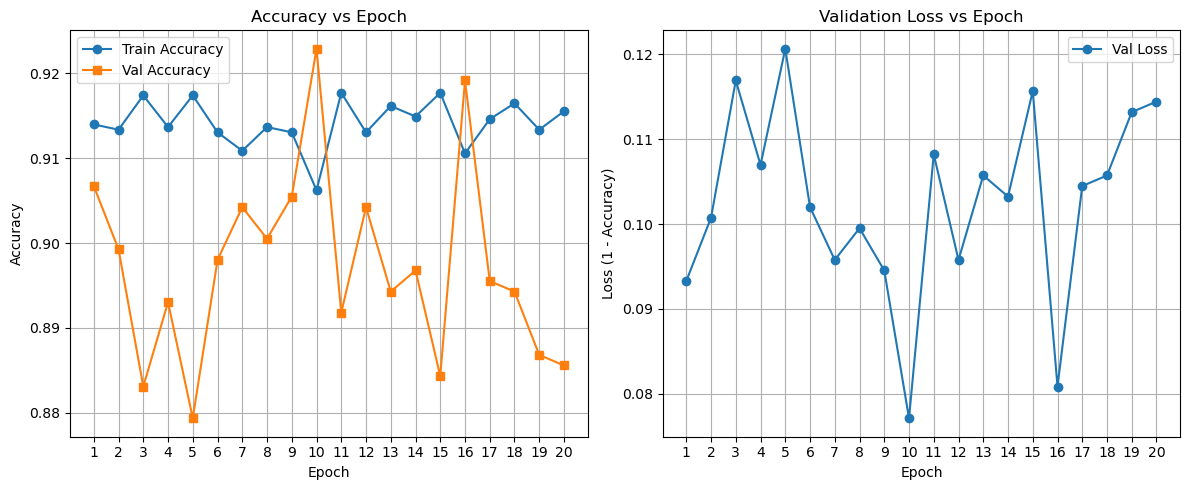

In [23]:
# Plot Accuracy and Loss vs Epoch
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_accs, marker='o', label='Train Accuracy')
plt.plot(epochs, val_accs, marker='s', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (1 - Accuracy)')
plt.title('Validation Loss vs Epoch')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Conclusion

This notebook implemented a Decision Tree classifier from scratch using Gini impurity and trained it across epochs 1–20. You should inspect the accuracy and loss plots to see how stable performance is across re-sampled splits. Max depth was limited to 5 to reduce overfitting
